In [1]:
#필요한 라이브러리를 로드합니다. 
import os
import math
import numpy as np
import tensorflow as tf

from PIL import Image
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.transform import resize
from glob import glob

from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *


In [2]:
import PIL
import skimage
import albumentations

print(tf.__version__)
print(np.__version__)
print(PIL.__version__)
print(skimage.__version__)
print(albumentations.__version__)

2.6.0
1.21.4
8.3.2
0.18.3
1.1.0


In [3]:
from albumentations import HorizontalFlip, RandomSizedCrop, Compose, OneOf, Resize

def build_augmentation(is_train=True):
    if is_train:  # 훈련용 데이터일 경우
        return Compose([
            HorizontalFlip(p=0.5),  # 50%의 확률로 좌우대칭
            RandomSizedCrop(  # 50%의 확률로 RandomSizedCrop
                min_max_height=(300, 370),
                w2h_ratio=370/1242,
                height=224,
                width=224,
                p=0.5
            ),
            Resize(  # 입력이미지를 224X224로 resize
                width=224,
                height=224
            )
        ])
    return Compose([  # 테스트용 데이터일 경우에는 224X224로 resize만 수행합니다.
        Resize(
            width=224,
            height=224
        )
    ])

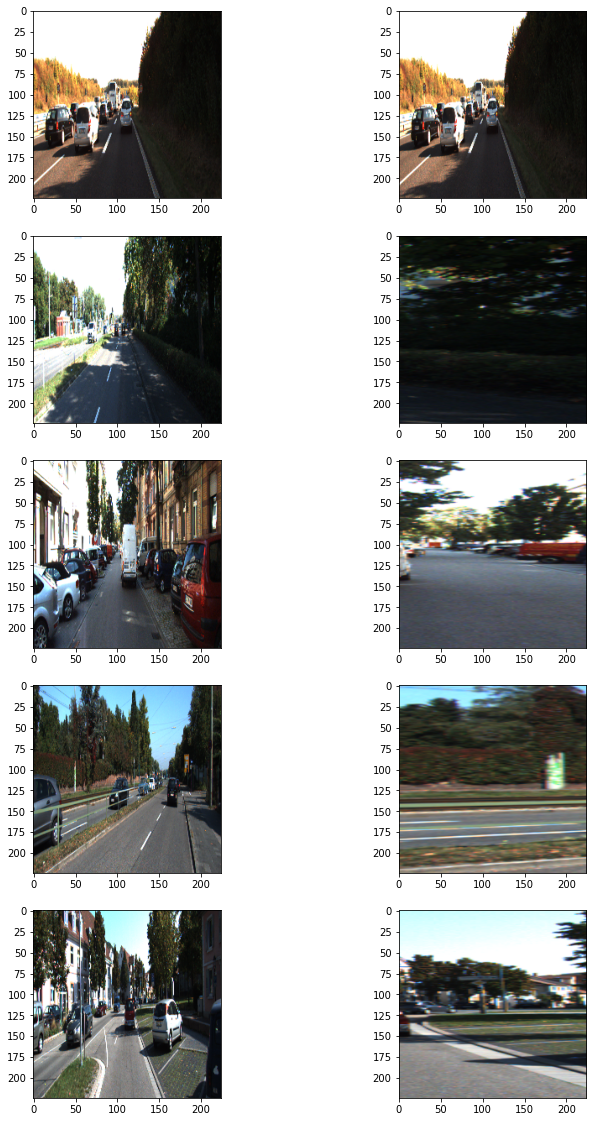

In [4]:
dir_path = os.getenv('HOME') + '/aiffel/semantic_segmentation/data/training'

augmentation_train = build_augmentation()
augmentation_test = build_augmentation(is_train=False)
input_images = glob(os.path.join(dir_path, "image_2", "*.png"))

# 훈련 데이터셋에서 5개만 가져와 augmentation을 적용해 봅시다.
plt.figure(figsize=(12, 20))
for i in range(5):
    image = imread(input_images[i])
    image_data = {"image": image}
    resized = augmentation_test(**image_data)
    processed = augmentation_train(**image_data)
    plt.subplot(5, 2, 2 * i + 1)
    plt.imshow(resized["image"])  # 왼쪽이 원본이미지
    plt.subplot(5, 2, 2 * i + 2)
    plt.imshow(processed["image"])  # 오른쪽이 augment된 이미지

plt.show()

class KittiGenerator(tf.keras.utils.Sequence):
    '''
    KittiGenerator는 tf.keras.utils.Sequence를 상속받습니다.
    우리가 KittiDataset을 원하는 방식으로 preprocess하기 위해서 Sequence를 커스텀해 사용합니다.
    '''
    def __init__(self,
                 dir_path,
                 batch_size=16,
                 img_size=(224, 224, 3),
                 output_size=(224, 224),
                 is_train=True,
                 augmentation=None):
        '''
        dir_path: dataset의 directory path입니다.
        batch_size: batch_size입니다.
        img_size: preprocess에 사용할 입력이미지의 크기입니다.
        output_size: ground_truth를 만들어주기 위한 크기입니다.
        is_train: 이 Generator가 학습용인지 테스트용인지 구분합니다.
        augmentation: 적용하길 원하는 augmentation 함수를 인자로 받습니다.
        '''
        self.dir_path = dir_path
        self.batch_size = batch_size
        self.is_train = is_train
        self.augmentation = augmentation
        self.img_size = img_size
        self.output_size = output_size

        # load_dataset()을 통해서 kitti dataset의 directory path에서 라벨과 이미지를 확인합니다.
        self.data = self.load_dataset()

    def load_dataset(self):
        # kitti dataset에서 필요한 정보(이미지 경로 및 라벨)를 directory에서 확인하고 로드하는 함수입니다.
        # 이때 is_train에 따라 test set을 분리해서 load하도록 해야합니다.
        input_images = glob(os.path.join(self.dir_path, "image_2", "*.png"))
        label_images = glob(os.path.join(self.dir_path, "semantic", "*.png"))
        input_images.sort()
        label_images.sort()
        assert len(input_images) == len(label_images)
        data = [_ for _ in zip(input_images, label_images)]

        if self.is_train:
            return data[:-30]
        return data[-30:]

    def __len__(self):
        # Generator의 length로서 전체 dataset을 batch_size로 나누고 소숫점 첫째자리에서 올림한 값을 반환합니다.
        return math.ceil(len(self.data) / self.batch_size)

    def __getitem__(self, index):
        # 입력과 출력을 만듭니다.
        # 입력은 resize 및 augmentation이 적용된 input image이고
        # 출력은 semantic label입니다.
        batch_data = self.data[
            index * self.batch_size:
            (index + 1) * self.batch_size
        ]
        inputs = np.zeros([self.batch_size, *self.img_size])
        outputs = np.zeros([self.batch_size, *self.output_size])

        for i, data in enumerate(batch_data):
            input_img_path, output_path = data
            _input = imread(input_img_path)
            _output = imread(output_path)
            _output = (_output == 7).astype(np.uint8) * 1
            data = {
                "image": _input,
                "mask": _output,
            }
            augmented = self.augmentation(**data)
            inputs[i] = augmented["image"] / 255
            outputs[i] = augmented["mask"]
        
        return inputs, outputs

    def on_epoch_end(self):
        # 한 epoch가 끝나면 실행되는 함수입니다. 학습 중인 경우에 순서를 random shuffle하도록 적용한 것을 볼 수 있습니다.
        self.indexes = np.arange(len(self.data))
        if self.is_train:
            np.random.shuffle(self.indexes)
            return self.indexes


In [6]:
augmentation = build_augmentation()
test_preproc = build_augmentation(is_train=False)
        
train_generator = KittiGenerator(
    dir_path, 
    augmentation=augmentation,
)

test_generator = KittiGenerator(
    dir_path, 
    augmentation=test_preproc,
    is_train=False
)

모델 구조 만들기
![u-net](u-net.png)

In [7]:
def build_model(input_shape=(224, 224, 3)):
    # 입력 레이어 정의
    inputs = Input(shape=input_shape)
    
    # 첫 번째 Convolution 블록(64)
    x = Conv2D(filters=64, kernel_size=(3,3), strides=1, activation="relu", padding="same")(inputs)
    x = Conv2D(filters=64, kernel_size=(3,3), strides=1, activation="relu", padding="same")(x)

    # 다운샘플링 (MaxPooling) 1
    down_1_out = x
    x = MaxPooling2D(pool_size=(2,2))(x)
    
    # 두 번째 Convolution 블록(128)
    x = Conv2D(filters=128, kernel_size=(3,3), strides=1, activation="relu", padding="same")(x)
    x = Conv2D(filters=128, kernel_size=(3,3), strides=1, activation="relu", padding="same")(x)

    # 다운샘플링 (MaxPooling) 2
    down_2_out = x
    x = MaxPooling2D(pool_size=(2,2))(x)
    
    # 세 번째 Convolution 블록(256) 
    x = Conv2D(filters=256, kernel_size=(3,3), strides=1, activation="relu", padding="same")(x)
    x = Conv2D(filters=256, kernel_size=(3,3), strides=1, activation="relu", padding="same")(x)

    # 다운샘플링 (MaxPooling) 3
    down_3_out = x
    x = MaxPooling2D(pool_size=(2,2))(x)
    
    # 네 번째 Convolution 블록(512)
    x = Conv2D(filters=512, kernel_size=(3,3), strides=1, activation="relu", padding="same")(x)
    x = Conv2D(filters=512, kernel_size=(3,3), strides=1, activation="relu", padding="same")(x)
    down_4_out = x

    # 다운샘플링 (MaxPooling) 4
    x = MaxPooling2D(pool_size=(2,2))(x)
    
    # 최소 resolution Convolution 블록(1024)
    x = Conv2D(filters=1024, kernel_size=(3,3), strides=1, activation="relu", padding="same")(x)
    x = Conv2D(filters=1024, kernel_size=(3,3), strides=1, activation="relu", padding="same")(x)
    
    # 업샘플링 (Conv2DTranspose) 1
    x = Conv2DTranspose(filters=512, kernel_size=(3,3), strides=2, activation="relu", padding="same")(x)
    
    # 스킵 커넥션과 네 번째 Convolution 블록(512)
    x = Concatenate(axis=-1)([down_4_out, x])
    x = Conv2D(filters=512, kernel_size=(3,3), strides=1, activation="relu", padding="same")(x)
    x = Conv2D(filters=512, kernel_size=(3,3), strides=1, activation="relu", padding="same")(x)

    # 업샘플링 (Conv2DTranspose) 2
    x = Conv2DTranspose(filters=256, kernel_size=(3,3), strides=2, activation="relu", padding="same")(x)
    x = Concatenate(axis=-1)([down_3_out, x])
    x = Conv2D(filters=256, kernel_size=(3,3), strides=1, activation="relu", padding="same")(x)
    x = Conv2D(filters=256, kernel_size=(3,3), strides=1, activation="relu", padding="same")(x)

    # 업샘플링 (Conv2DTranspose) 3
    x = Conv2DTranspose(filters=128, kernel_size=(3,3), strides=2, activation="relu", padding="same")(x)
    x = Concatenate(axis=-1)([down_2_out, x])
    x = Conv2D(filters=128, kernel_size=(3,3), strides=1, activation="relu", padding="same")(x)
    x = Conv2D(filters=128, kernel_size=(3,3), strides=1, activation="relu", padding="same")(x)

    # 업샘플링 (Conv2DTranspose) 4
    x = Conv2DTranspose(filters=64, kernel_size=(3,3), strides=2, activation="relu", padding="same")(x)
    x = Concatenate(axis=-1)([down_1_out, x])
    x = Conv2D(filters=64, kernel_size=(3,3), strides=1, activation="relu", padding="same")(x)
    x = Conv2D(filters=64, kernel_size=(3,3), strides=1, activation="relu", padding="same")(x)

    # 출력 레이어 (sigmoid 활성화)
    outputs = Conv2D(filters=1, kernel_size=(1,1), activation="sigmoid")(x)
    
    # 모델 정의
    model = tf.keras.Model(inputs, outputs)

    return model

## U-net 초기 실험

In [11]:
model_path = os.getenv('HOME')+'/aiffel/semantic_segmentation/seg_model_unet.h5'

model = build_model()
model.compile(optimizer = Adam(1e-4), loss = 'binary_crossentropy')
history = model.fit(
     train_generator,
     validation_data=test_generator,
     steps_per_epoch=len(train_generator),
     epochs=100,
 )

model.save(model_path)  #학습한 모델을 저장해 주세요.

Epoch 1/100
11/11 [==============================] - 11s 801ms/step - loss: 0.6762 - val_loss: 0.6557
Epoch 2/100
11/11 [==============================] - 8s 715ms/step - loss: 0.6242 - val_loss: 0.5968
Epoch 3/100
11/11 [==============================] - 8s 721ms/step - loss: 0.5788 - val_loss: 0.5616
Epoch 4/100
11/11 [==============================] - 8s 729ms/step - loss: 0.5411 - val_loss: 0.6029
Epoch 5/100
11/11 [==============================] - 8s 725ms/step - loss: 0.6122 - val_loss: 0.5936
Epoch 6/100
11/11 [==============================] - 8s 735ms/step - loss: 0.5262 - val_loss: 0.5407
Epoch 7/100
11/11 [==============================] - 9s 742ms/step - loss: 0.4377 - val_loss: 0.3987
Epoch 8/100
11/11 [==============================] - 9s 749ms/step - loss: 0.3337 - val_loss: 0.3528
Epoch 9/100
11/11 [==============================] - 9s 745ms/step - loss: 0.2881 - val_loss: 0.3404
Epoch 10/100
11/11 [==============================] - 9s 747ms/step - loss: 0.2723 - val_l

11/11 [==============================] - 9s 750ms/step - loss: 0.1171 - val_loss: 0.1437
Epoch 82/100
11/11 [==============================] - 9s 755ms/step - loss: 0.1169 - val_loss: 0.1382
Epoch 83/100
11/11 [==============================] - 9s 752ms/step - loss: 0.1200 - val_loss: 0.1373
Epoch 84/100
11/11 [==============================] - 9s 752ms/step - loss: 0.0978 - val_loss: 0.1858
Epoch 85/100
11/11 [==============================] - 9s 749ms/step - loss: 0.1181 - val_loss: 0.1756
Epoch 86/100
11/11 [==============================] - 9s 749ms/step - loss: 0.0986 - val_loss: 0.1719
Epoch 87/100
11/11 [==============================] - 9s 748ms/step - loss: 0.1064 - val_loss: 0.1462
Epoch 88/100
11/11 [==============================] - 9s 747ms/step - loss: 0.1222 - val_loss: 0.1411
Epoch 89/100
11/11 [==============================] - 9s 748ms/step - loss: 0.0972 - val_loss: 0.1717
Epoch 90/100
11/11 [==============================] - 9s 749ms/step - loss: 0.1143 - val_loss: 

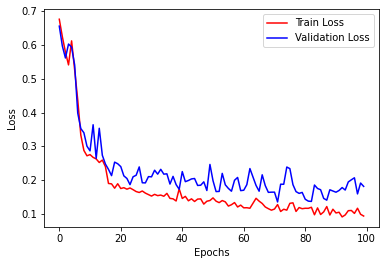

In [13]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], 'r', label='Train Loss')  # 빨간색 (r)
plt.plot(history.history['val_loss'], 'b', label='Validation Loss')  # 파란색 (b)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

시맨틱 세그멘테이션 모델 시각화

In [9]:
# 미리 준비한 모델을 불러오려면 아래 주석을 해제하세요
model_path = dir_path + '/seg_model_unet.h5' 

model = tf.keras.models.load_model(model_path)

In [10]:
def get_output(model, preproc, image_path, output_path):
    origin_img = imread(image_path)
    data = {"image":origin_img}
    processed = preproc(**data)
    output = model(np.expand_dims(processed["image"]/255,axis=0))
    output = (output[0].numpy()>0.5).astype(np.uint8).squeeze(-1)*255  #0.5라는 threshold를 변경하면 도로인식 결과범위가 달라집니다.
    output = Image.fromarray(output)
    background = Image.fromarray(origin_img).convert('RGBA')
    output = output.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
    output = Image.blend(background, output, alpha=0.5)
    output.show()
    return output

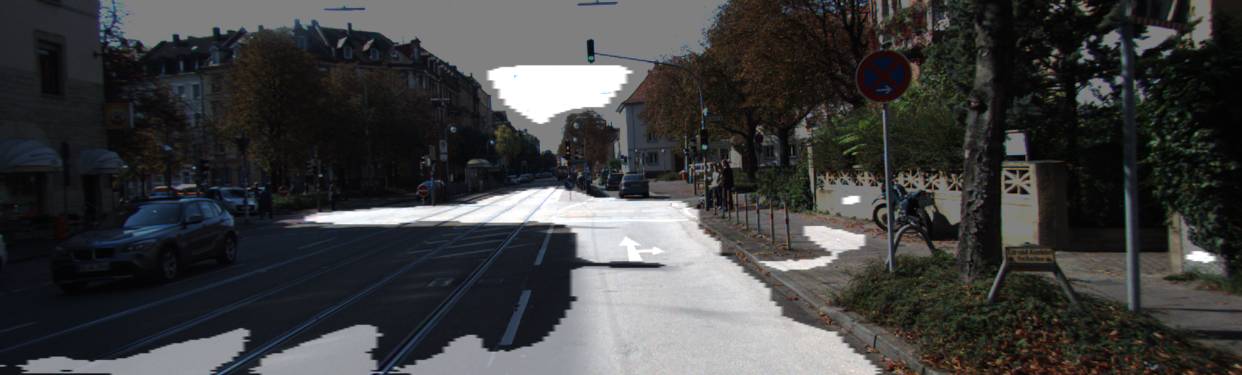

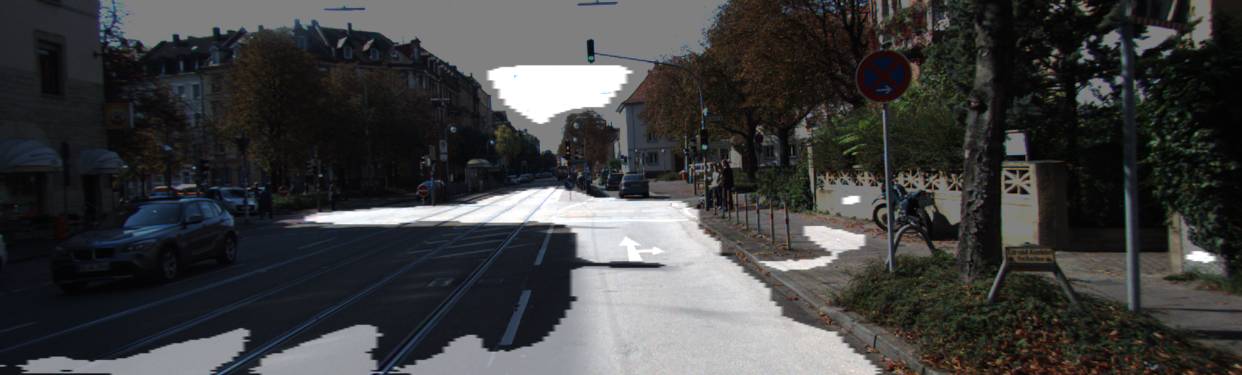

In [11]:
# 완성한 뒤에는 시각화한 결과를 눈으로 확인해봅시다!
i = 1    # i값을 바꾸면 테스트용 파일이 달라집니다. 
get_output(
     model, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png'
 )

세그멘테이션 성능을 정량적으로 측정하기 위해 IoU를 구현하여 시각화하기
- IoU = (intersection / union)


In [12]:
# IoU를 계산하려면 모델이 도로 영역이라고 판단한 부분이 1로, 나머지 부분이 0으로 표시된 행렬, 
# 그리고 라벨 데이터에서 도로 영역이 1, 나머지 부분이 0으로 표시된 행렬이 필요합니다. 
def calculate_iou_score(target, prediction):
    # target과 prediction이 1인 부분이 겹치는 영역 (intersection)
    intersection = np.logical_and(target == 1, prediction == 1)

    # target과 prediction 중 적어도 하나가 1인 영역 (union)
    union = np.logical_or(target == 1, prediction == 1)

    # IoU 계산 (0으로 나누는 경우 방지)
    iou_score = np.sum(intersection) / np.sum(union) if np.sum(union) != 0 else 0.0

    print('IoU : %f' % iou_score)
    return iou_score

In [15]:
# 모든 데이터셋 한 번에 가져오기
threshold=0.5
ground_truths, _ = zip(*[test_generator[i] for i in range(len(test_generator))])
ground_truths = np.concatenate(ground_truths, axis=0)  # 배치 차원 합치기

# 예측 수행
predictions = model.predict(test_generator)
binary_predictions = (predictions > threshold).astype(np.uint8)

# IoU 계산
iou_scores = np.array([calculate_iou_score(gt, pred) for gt, pred in zip(ground_truths, binary_predictions)])

# 평균 IoU 출력
print(f"Mean IoU Score: {iou_scores.mean():.4f}")

IoU : 0.081563
IoU : 0.100130
IoU : 0.015193
IoU : 0.186926
IoU : 0.042092
IoU : 0.212810
IoU : 0.147769
IoU : 0.119570
IoU : 0.095959
IoU : 0.130627
IoU : 0.130317
IoU : 0.243006
IoU : 0.146565
IoU : 0.098529
IoU : 0.054824
IoU : 0.008208
IoU : 0.064871
IoU : 0.400717
IoU : 0.023668
IoU : 0.078043
IoU : 0.143820
IoU : 0.105686
IoU : 0.140484
IoU : 0.209622
IoU : 0.123656
IoU : 0.048123
IoU : 0.105008
IoU : 0.148417
IoU : 0.300622
IoU : 0.079302
IoU : 0.000000
IoU : 0.000000
Mean IoU Score: 0.1183


In [16]:
def get_output(model, preproc, image_path, output_path, label_path):
    origin_img = imread(image_path)
    data = {"image":origin_img}
    processed = preproc(**data)
    output = model(np.expand_dims(processed["image"]/255,axis=0))
    output = (output[0].numpy()>=0.5).astype(np.uint8).squeeze(-1)*255  #0.5라는 threshold를 변경하면 도로인식 결과범위가 달라집니다.
    prediction = output/255   # 도로로 판단한 영역
    
    output = Image.fromarray(output)
    background = Image.fromarray(origin_img).convert('RGBA')
    output = output.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
    output = Image.blend(background, output, alpha=0.5)
    output.show()   # 도로로 판단한 영역을 시각화!
     
    if label_path:   
        label_img = imread(label_path)
        label_data = {"image":label_img}
        label_processed = preproc(**label_data)
        label_processed = label_processed["image"]
        target = (label_processed == 7).astype(np.uint8)*1   # 라벨에서 도로로 기재된 영역

        return output, prediction, target
    else:
        return output, prediction, _

In [17]:
str(1).zfill(3)

'001'

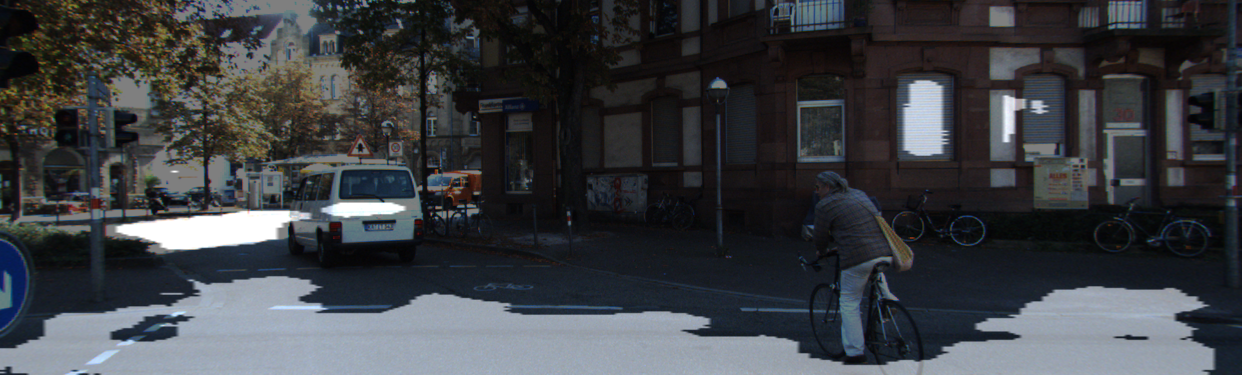

(<PIL.Image.Image image mode=RGBA size=1242x375 at 0x7A49813E58B0>,
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 1., ..., 0., 0., 0.],
        [1., 0., 1., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1]], dtype=uint8))

In [19]:
# 완성한 뒤에는 시각화한 결과를 눈으로 확인해봅시다!
i = 2    # i값을 바꾸면 테스트용 파일이 달라집니다. 
get_output(
     model, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
     label_path=dir_path + f'/semantic/{str(i).zfill(6)}_10.png'
 )

# U-net++ 구현

![u-net++](u-net++.png)

In [7]:
# from official Unet++ repo의 x-net를 참고하여 구현할 것
# https://github.com/MrGiovanni/UNetPlusPlus/blob/e145ba63862982bf1099cf2ec11d5466b434ae0b/keras/segmentation_models/xnet/builder.py#L12

In [20]:
def conv_block(x, filters, use_batchnorm=True):
    x = Conv2D(filters, (3,3), padding="same", activation="relu")(x)
    if use_batchnorm:
        x = BatchNormalization()(x)
    return x

def dense_skip_connection(x, skip_connections):
    """ 기존 skip_connection에 여러 개의 Conv2D 추가 (U-Net++ 스타일) """
    for skip in skip_connections:
        x = Concatenate()([x, skip])
        x = conv_block(x, filters=x.shape[-1])
    return x

def build_unet_plus_plus(input_shape=(224, 224, 3), classes=1, filters=(64,128,256,512,1024), use_batchnorm=True):
    inputs = Input(shape=input_shape)
    x = inputs  

    # **Encoder 구현 (Backbone 제거)**
    skip_connections = []
    for f in filters[:-1]:  # 마지막 filters 제외 (최대 깊이)
        x = conv_block(x, f, use_batchnorm)
        x = conv_block(x, f, use_batchnorm)  # 기존 U-Net 스타일로 두 개의 Conv 사용
        skip_connections.append(x)  # 스킵 연결 저장
        x = MaxPooling2D((2, 2))(x)  # 다운샘플링

    # **Bottleneck Layer (가장 깊은 레이어)**
    x = conv_block(x, filters[-1], use_batchnorm)
    x = conv_block(x, filters[-1], use_batchnorm)

    # **Decoder (U-Net++ 스타일)**
#     for skip in reversed(skip_connections):  # 스킵 연결을 역순으로 사용
#         x = Conv2DTranspose(size=(2,2))(x)
#         x = dense_skip_connection(x, [skip])  # 스킵 연결 적용
    for f, skip in zip(reversed(filters[:-1]), reversed(skip_connections)):   # upsampling의 경량화된 버전
        x = Conv2DTranspose(f, (2, 2), strides=(2, 2), padding="same")(x)  # ⬅️ filters를 역순으로 적용
        x = dense_skip_connection(x, [skip])  # 스킵 연결 적용
        
        
    # **최종 출력 레이어**
    outputs = Conv2D(classes, (1,1), activation="sigmoid")(x)
    
    return Model(inputs, outputs)

## KITTI 데이터셋 구축  
(U-Net++는 메모리 사용량이 U-Net보다 꽤 많아지므로, 배치 사이즈를 적절히 조절)

In [21]:
augmentation = build_augmentation()
test_preproc = build_augmentation(is_train=False)
        
train_generator = KittiGenerator(
    dir_path, 
    batch_size=8,
    augmentation=augmentation,
)

test_generator = KittiGenerator(
    dir_path, 
    batch_size=8,
    augmentation=test_preproc,
    is_train=False
)

In [22]:
import tensorflow.keras.backend as K
def dice_coef(y_true, y_pred, smooth=1e-6):
    """
    Dice Coefficient 계산 함수
    Args:
        y_true: 실제 마스크 (Ground Truth)
        y_pred: 모델이 예측한 마스크 (Prediction)
        smooth: 분모가 0이 되는 것을 방지하는 작은 값 (epsilon)

    Returns:
        Dice Coefficient 값 (0 ~ 1 사이)
    """
    y_true_f = K.flatten(y_true)  # y_true를 1D 벡터로 변환
    y_pred_f = K.flatten(y_pred)  # y_pred를 1D 벡터로 변환

    intersection = K.sum(y_true_f * y_pred_f)  # 두 마스크가 겹치는 부분의 픽셀 합
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

In [23]:
def dice_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

In [24]:
def bce_dice_loss(y_true, y_pred, alpha=0.5, beta=0.5):
    bce = K.binary_crossentropy(y_true, y_pred)
    dice = dice_loss(y_true, y_pred)
    return alpha * bce + beta * dice

# 초기 실험

In [13]:
unet_plus_plus_model_path = os.getenv('HOME')+'/aiffel/semantic_segmentation/seg_model_unet_plus_plus.h5'

unet_plus_plus_model = build_unet_plus_plus()

unet_plus_plus_model.compile(optimizer=Adam(1e-4), loss=bce_dice_loss)

history = unet_plus_plus_model.fit(
     train_generator,
     validation_data=test_generator,
     steps_per_epoch=len(train_generator),
     epochs=100,
)

unet_plus_plus_model.save(unet_plus_plus_model_path)

Epoch 1/100
22/22 [==============================] - 28s 509ms/step - loss: 0.5057 - val_loss: 0.6861
Epoch 2/100
22/22 [==============================] - 11s 485ms/step - loss: 0.4242 - val_loss: 0.6808
Epoch 3/100
22/22 [==============================] - 11s 490ms/step - loss: 0.3567 - val_loss: 0.6449
Epoch 4/100
22/22 [==============================] - 11s 492ms/step - loss: 0.3333 - val_loss: 0.6424
Epoch 5/100
22/22 [==============================] - 11s 499ms/step - loss: 0.2701 - val_loss: 0.6514
Epoch 6/100
22/22 [==============================] - 11s 496ms/step - loss: 0.3073 - val_loss: 0.7273
Epoch 7/100
22/22 [==============================] - 11s 491ms/step - loss: 0.2881 - val_loss: 0.6507
Epoch 8/100
22/22 [==============================] - 11s 488ms/step - loss: 0.2682 - val_loss: 0.7204
Epoch 9/100
22/22 [==============================] - 11s 490ms/step - loss: 0.2505 - val_loss: 0.7016
Epoch 10/100
22/22 [==============================] - 11s 494ms/step - loss: 0.227

22/22 [==============================] - 11s 489ms/step - loss: 0.1152 - val_loss: 0.3036
Epoch 81/100
22/22 [==============================] - 11s 496ms/step - loss: 0.1152 - val_loss: 0.2182
Epoch 82/100
22/22 [==============================] - 11s 490ms/step - loss: 0.1179 - val_loss: 0.2631
Epoch 83/100
22/22 [==============================] - 11s 489ms/step - loss: 0.1173 - val_loss: 0.2659
Epoch 84/100
22/22 [==============================] - 11s 490ms/step - loss: 0.1107 - val_loss: 0.2934
Epoch 85/100
22/22 [==============================] - 11s 489ms/step - loss: 0.1155 - val_loss: 0.2892
Epoch 86/100
22/22 [==============================] - 11s 489ms/step - loss: 0.1092 - val_loss: 0.3975
Epoch 87/100
22/22 [==============================] - 11s 489ms/step - loss: 0.1053 - val_loss: 0.3485
Epoch 88/100
22/22 [==============================] - 11s 488ms/step - loss: 0.1154 - val_loss: 0.2888
Epoch 89/100
22/22 [==============================] - 11s 490ms/step - loss: 0.1122 - 

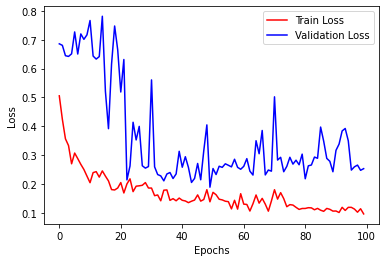

In [14]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], 'r', label='Train Loss')  # 빨간색 (r)
plt.plot(history.history['val_loss'], 'b', label='Validation Loss')  # 파란색 (b)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

[디버깅] Unet++ 모델 구현체가 loss를 최종 출력만을 고려하여 계산하므로 이를 multi output으로부터 손실으로 확장함

In [25]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, BatchNormalization, Activation, Concatenate
from tensorflow.keras.models import Model

def conv_block(x, filters, use_batchnorm=True):
    x = Conv2D(filters, (3,3), padding="same")(x)
    if use_batchnorm:
        x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x

def dense_skip_connection(x, skips):
    """ 여러 개의 skip connection을 연결하는 함수 """
    for skip in skips:
        x = Concatenate()([x, skip])
        x = conv_block(x, x.shape[-1])
    return x

def build_unet_plus_plus(input_shape=(224, 224, 3), classes=1, filters=(64,128,256,512,1024), use_batchnorm=True):
    inputs = Input(shape=input_shape)
    encoder_layers = {}

    # **Encoder (Backbone 없이 직접 구현)**
    x = inputs  
    for i, f in enumerate(filters[:-1]):  
        x = conv_block(x, f, use_batchnorm)
        x = conv_block(x, f, use_batchnorm)  
        encoder_layers[f"X{i},0"] = x  # 저장
        x = MaxPooling2D((2, 2))(x)  

    # **Bottleneck Layer**
    x = conv_block(x, filters[-1], use_batchnorm)
    x = conv_block(x, filters[-1], use_batchnorm)
    encoder_layers[f"X{len(filters)-1},0"] = x  # Bottleneck 저장

    # **Decoder (U-Net++ 구조)**
    decoder_layers = {}
    for depth in range(len(filters)-2, -1, -1):  # 깊이별 decoder 생성
        for level in range(1, len(filters)-depth):  # 여러 레벨에서 업샘플링 수행
            x = Conv2DTranspose(filters[depth], (2,2), strides=(2,2), padding="same")(encoder_layers[f"X{depth+1},{level-1}"])
            x = dense_skip_connection(x, [encoder_layers[f"X{depth},{level-1}"]])  # 여러 스킵 연결
            
            decoder_layers[f"X{depth},{level}"] = x  # 저장
            encoder_layers[f"X{depth},{level}"] = x  # 다음 레벨에서도 사용

    # **최종 출력 (동일한 해상도로)**
    outputs = [Conv2D(classes, (1,1), activation="sigmoid", name=f"X0_{i+1}")(decoder_layers[f"X0,{i+1}"]) for i in range(4)]

    return Model(inputs, outputs)

# 모델 생성
model = build_unet_plus_plus()
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 224, 224, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 224, 224, 64) 256         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 224, 224, 64) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [26]:
def bce_dice_loss(y_true, y_pred):
    bce = tf.keras.losses.BinaryCrossentropy()(y_true, y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    dice = (2. * intersection) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + 1e-6)
    return bce - tf.math.log(dice)

losses = {f"X0_{i+1}": bce_dice_loss for i in range(4)}

model.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss=losses)

In [ ]:
unet_plus_plus_model_path = os.getenv('HOME')+'/aiffel/semantic_segmentation/seg_model_unet_plus_plus_2.h5'

unet_plus_plus_model = build_unet_plus_plus()

unet_plus_plus_model.compile(optimizer=Adam(1e-4), loss=losses)

history = unet_plus_plus_model.fit(
     train_generator,
     validation_data=test_generator,
     steps_per_epoch=len(train_generator),
     epochs=100,
)

unet_plus_plus_model.save(unet_plus_plus_model_path)

Epoch 1/100
21/22 [===========================>..] - ETA: 1s - loss: 5.2681 - X0_1_loss: 1.4080 - X0_2_loss: 1.3953 - X0_3_loss: 1.2537 - X0_4_loss: 1.2111

## U-Net 과 U-Net++ 모델이 수행한 세그멘테이션 결과 분석  

두 모델의 정량적, 정성적 성능을 비교  
시각화, IoU 계산

In [ ]:
# model_path = dir_path + '/seg_model_unet.h5' 

unet_plus_plus_model = tf.keras.models.load_model(unet_plus_plus_model_path)


In [ ]:
# 모든 데이터셋 한 번에 가져오기
ground_truths, _ = zip(*[val_generator[i] for i in range(len(val_generator))])
ground_truths = np.concatenate(ground_truths, axis=0)  # 배치 차원 합치기

# 예측 수행
predictions = unet_plus_plus_model.predict(val_generator)
binary_predictions = (predictions > threshold).astype(np.uint8)

# IoU 계산
iou_scores = np.array([calculate_iou_score(gt, pred) for gt, pred in zip(ground_truths, binary_predictions)])

# 평균 IoU 출력
print(f"Mean IoU Score: {iou_scores.mean():.4f}")

이미지 정성적 시각화

In [ ]:
i = 2    # i값을 바꾸면 테스트용 파일이 달라집니다. 
get_output(
     model, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
     label_path=dir_path + f'/semantic/{str(i).zfill(6)}_10.png'
 )